<a href="https://colab.research.google.com/github/lokinSai/GAN-Implementation/blob/infoGAN/InfoGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# InfoGAN
The reason we tried to implement InfoGAN is to solve two biggest weakness of traditional GAN:
1.   Traditional GAN cannot control the image that one wish to generate.
2.   Traditional GAN cannot produce diverse images.


## Prerequisites:
1.   path to image files
2.   convert image files to h5 files



# Library Dependencies & Configuration

In [0]:
import os
import time
import h5py
import functools
from glob import glob
from PIL import Image

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import random_normal_initializer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input, Model, layers
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, \
    Conv2D, Conv2DTranspose, Reshape, Flatten, Dropout

# Model Configuration
buffer_size = 6000
batch_size = 32
epochs = 100

# Noise Configuration
noise_dim = 100
n_control_cat = 8

# Dataset Configuration
img_filename='cartoon_dataset.h5'
img_key='cartoon'

# Prepare Dataset

1. Download Cartoon files from [Google Cartoon Dataset](https://google.github.io/cartoonset/)
2. Unzip files and convert images to h5 file

To make it simple and work better on Google Colab, I ran through these two steps on my local machine and uploaded the converted h5 file to Google Drive. \\
Here we will simply download from [google drive](https://drive.google.com/file/d/1ONB__BxV2uulKu6hvUFaWoNff6pwzQu0/view) where I uploaded the h5 file.

## Download Dataet from Google Drive

In [2]:
!gdown --id 1ONB__BxV2uulKu6hvUFaWoNff6pwzQu0

Downloading...
From: https://drive.google.com/uc?id=1ONB__BxV2uulKu6hvUFaWoNff6pwzQu0
To: /content/cartoon_dataset.h5
492MB [00:04, 114MB/s]


## Load h5 images as Tensorflow Dataset

The best practice to work on input data is using Tensorflow Dataset API which provides batching and shuffling. Here we create a generator that will read images from h5 image file and pass such generator to Tensorflow Dataset API.

In [0]:
class Generator:
    def __init__(self, filename, key):
        self.filename = filename
        self.key = key

    def __call__(self):
        with h5py.File(self.filename, 'r') as f:
            for im in f[self.key]:
                yield im

class ImageUtil():
    def __init__(self, filename, key):
        self.filename = filename
        self.key = key

    def get_h5_images(self):
        gen = Generator(self.filename, self.key)
        dataset = tf.data.Dataset.from_generator(gen, tf.float32)
        return dataset


In [0]:
train_dataset = ImageUtil(filename=img_filename, key=img_key).get_h5_images()
train_dataset = train_dataset.shuffle(buffer_size).batch(batch_size)

# InfoGAN Model Architecture

Apart from traditional GAN model that only input noises. InfoGAN randomly generate **control categories** as input. The idea is that different control category should present different features (e.g hair styles, skin colors). As a result, our output model also incudes a multiclass classification model to also pass such control categories as ground truth.

The overall architecture is referenced from [How to Develop an Information Maximizing GAN (InfoGAN) in Keras](https://machinelearningmastery.com/how-to-develop-an-information-maximizing-generative-adversarial-network-infogan-in-keras/)



## Define Generator

In [5]:
def make_generator_model():
    # weight initialization
    init = random_normal_initializer(stddev=0.02)
    # image generator input
    in_noise = Input(shape=(noise_dim + n_control_cat,))
    gen = Dense(16*16*256, use_bias=False, kernel_initializer=init)(in_noise)
    gen = BatchNormalization()(gen)
    gen = LeakyReLU(alpha=0.1)(gen)
    gen = Dropout(0.3)(gen)

    gen = Reshape((16, 16, 256))(gen)

    gen = Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same',
        use_bias=False, kernel_initializer=init)(gen)
    gen = BatchNormalization()(gen)
    gen = LeakyReLU(alpha=0.1)(gen)

    gen = Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same',
        use_bias=False, kernel_initializer=init)(gen)
    gen = BatchNormalization()(gen)
    gen = LeakyReLU(alpha=0.1)(gen)

    out_layer = Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same',
        use_bias=False, kernel_initializer=init, activation='tanh')(gen)

    model = Model(inputs=in_noise, outputs=out_layer)

    return model

g_model = make_generator_model()
g_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 108)]             0         
_________________________________________________________________
dense (Dense)                (None, 65536)             7077888   
_________________________________________________________________
batch_normalization (BatchNo (None, 65536)             262144    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 65536)             0         
_________________________________________________________________
dropout (Dropout)            (None, 65536)             0         
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 128)       819200

## Define Discriminator & Auxiliary model

In [6]:
def make_discriminator_model():
    init = tf.random_normal_initializer(stddev=0.02)

    in_image = Input(shape=(64,64,3))
    d = Conv2D(64, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
    d = LeakyReLU(alpha=0.1)(d)
    d = Dropout(0.3)(d)

    d = Conv2D(128, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = LeakyReLU(alpha=0.1)(d)
    d = Dropout(0.3)(d)

    d = Flatten()(d)

    out_classifier = Dense(1, activation='sigmoid')(d)

    d_model = Model(inputs=in_image, outputs=out_classifier)
    d_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))

    q = Dense(128)(d)
    q = BatchNormalization()(q)
    q = LeakyReLU(alpha=0.1)(q)
    out_codes = Dense(n_control_cat, activation='softmax')(q)

    q_model = Model(inputs=in_image, outputs=out_codes)

    return d_model, q_model

d_model, q_model = make_discriminator_model()
d_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 128)       0   

## Combine GAN Model

Discriminator model train on its own. \\
Generator and Auxiliary model train together.

In [7]:
def make_gan_model(g_model, d_model, q_model):
    # make weights in the discriminator (some shared with the q model) as not trainable
    d_model.trainable = False
    # connect g outputs to d inputs
    d_output = d_model(g_model.output)
    # connect g outputs to q inputs
    q_output = q_model(g_model.output)
    # define composite model
    model = Model(inputs=g_model.input, outputs=[d_output, q_output])
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'categorical_crossentropy'], optimizer=opt)
    return model

gan_model = make_gan_model(g_model, d_model, q_model)
gan_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 108)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 65536)        7077888     input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 65536)        262144      dense[0][0]                      
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 65536)        0           batch_normalization[0][0]        
____________________________________________________________________________________________

# Training Steps

## Noise Generator

Generate Gaussian noise and control categories as input for generator. Control Categories will also be used as a ground truth for multiclass classification output.

In [0]:
def generate_noise_and_control():
    noise = tf.random.normal([batch_size, noise_dim])
    rand_cat = np.random.randint(0, n_control_cat, size=batch_size)
    control_cat = tf.keras.utils.to_categorical(rand_cat, num_classes=n_control_cat)
    noise = tf.concat([noise, control_cat], axis=1)
    return noise, control_cat

## Training per step

In [0]:
def infoGan_train_step(images, g_model, d_model, gan_model):
    noise, control_cat = generate_noise_and_control()

    d_loss_true = d_model.train_on_batch(images, np.ones((batch_size, 1)))

    generated_images = g_model.predict(noise)
    d_loss_fake = d_model.train_on_batch(generated_images, np.zeros((batch_size, 1)))

    # inverted labels for fake images
    # train g_model & q_model at the same time
    _, g_1, g_2 = gan_model.train_on_batch(noise, [np.ones((batch_size, 1)), control_cat])
    return d_loss_true, d_loss_fake, g_1, g_2

# Image Helper

Generate images after n epochs to show the training progress. This class will generate n_sample for each category. Images will also be saved to **/images** folder

In [0]:
class ImageHelper():
    def __init__(self, noise_dim, num_examples_to_generate=16, img_dir='images'):
        try:
            os.mkdir(img_dir)
        except OSError as error:
            pass
        self.img_dir = img_dir
        self.num_examples_to_generate = num_examples_to_generate
        self.noise_dim = noise_dim
        self.seed = tf.random.normal([num_examples_to_generate, noise_dim])

    def _generate_noise_and_control(self, n_control_cat, n_sample_per_category):
        noise = tf.random.normal([n_sample_per_category, self.noise_dim])
        # repeat same noise for each control category
        noise = tf.concat([noise for _ in range(n_control_cat)], axis=0)
        # generate images for each control category
        rand_cat = []
        for cat in range(n_control_cat):
            rand_cat.extend([cat for _ in range(n_sample_per_category)])
        control_cat = tf.keras.utils.to_categorical(rand_cat, num_classes=n_control_cat)
        noise = tf.concat([noise, control_cat], axis=1)
        return noise

    def generate_and_save_images_control_cat(self, model, epoch, n_control_cat, n_sample_per_category=4):
        predictions = model.predict(
            self._generate_noise_and_control(n_control_cat, n_sample_per_category))
        fig = plt.figure(figsize=(n_control_cat, n_sample_per_category))

        for i in range(predictions.shape[0]):
            plt.subplot(n_control_cat, n_sample_per_category, i+1)
            plt.imshow((predictions[i, :, :, :] + 1) / 2.0)
            plt.axis('off')

        plt.savefig('{}/image_at_epoch_{:04d}.png'.format(self.img_dir, epoch))
        plt.show

# Train Runner

Time for epoch 1 is 41.30933332443237 sec
Time for epoch 2 is 33.40665316581726 sec
Time for epoch 3 is 33.25793957710266 sec
Time for epoch 4 is 32.13008666038513 sec
Time for epoch 5 is 31.864348888397217 sec
Time for epoch 6 is 31.603728771209717 sec
Time for epoch 7 is 32.423977851867676 sec
Time for epoch 8 is 33.10986590385437 sec
Time for epoch 9 is 33.19107484817505 sec
Time for epoch 10 is 33.751611948013306 sec
Time for epoch 11 is 33.20007252693176 sec
Time for epoch 12 is 33.16711163520813 sec
Time for epoch 13 is 32.9935405254364 sec
Time for epoch 14 is 33.24874806404114 sec
Time for epoch 15 is 33.57160830497742 sec
Time for epoch 16 is 33.143635749816895 sec
Time for epoch 17 is 33.3130042552948 sec
Time for epoch 18 is 33.09099555015564 sec
Time for epoch 19 is 33.04037046432495 sec
Time for epoch 20 is 33.70735955238342 sec
Time for epoch 21 is 33.07025170326233 sec
Time for epoch 22 is 33.04406189918518 sec
Time for epoch 23 is 32.96180820465088 sec
Time for epoch 24

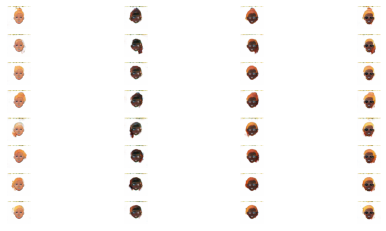

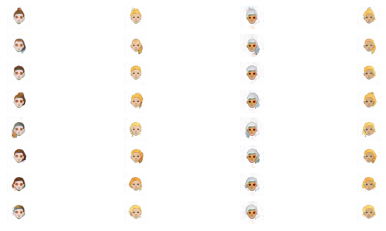

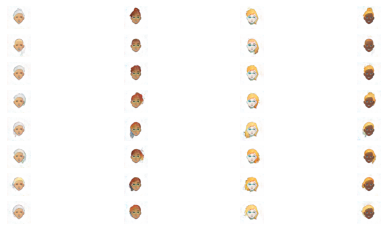

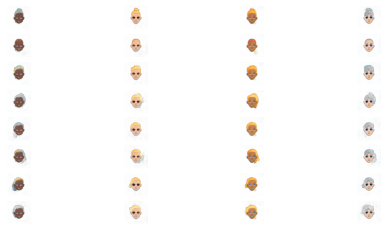

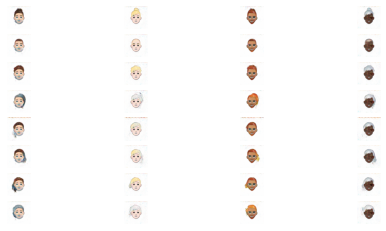

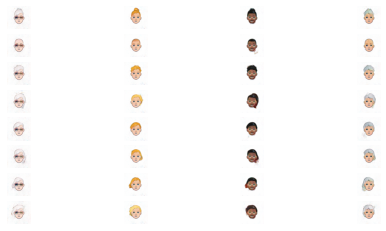

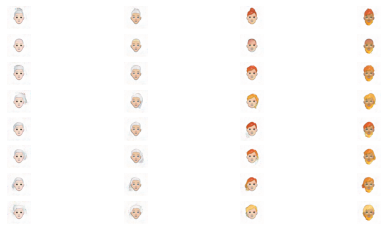

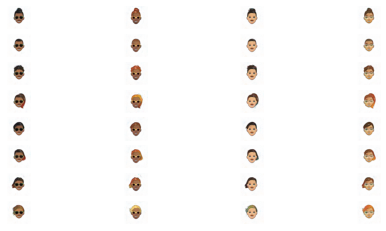

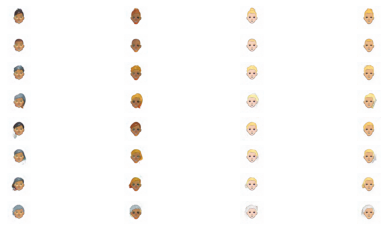

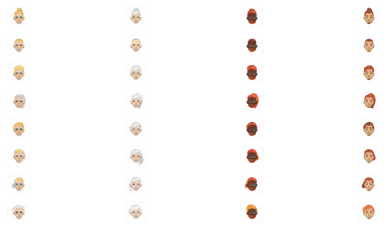

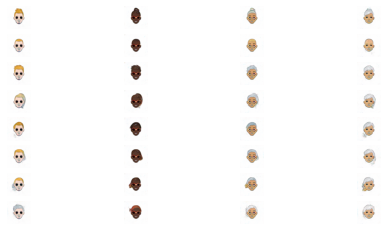

In [11]:
image_helper = ImageHelper(noise_dim=noise_dim)

for epoch in range(epochs):
    start = time.time()
    for image_batch in train_dataset:
        if image_batch.shape[0] < batch_size:
            break
        infoGan_train_step(image_batch, g_model, d_model, gan_model)

    if (epoch + 1) % 10 == 0:
        image_helper.generate_and_save_images_control_cat(g_model, epoch+1, n_control_cat)

    print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

# Generate after the final epoch
image_helper.generate_and_save_images_control_cat(g_model, epochs, n_control_cat)
